In [1]:
%matplotlib inline
import numpy as np
from functools import reduce
import operator

import matplotlib.pyplot as plt

# Larger figure size
fig_size = [14, 8]
plt.rcParams['figure.figsize'] = fig_size

In [2]:
H = np.array([0xa4f800, 0xf68400, 0x7b4200, 0x3da100, 0x1ed080, 0xab9040, 0xf13020, 0xdc6010, 0x6e3008, 0x93e004, 0x49f002, 0xc75001])
Bt = np.array([reduce(operator.or_, (((H[j] >> (23-k)) & 1) << (11-j) for j in range(12))) for k in range(12)])
B = H >> 12

In [3]:
def encode_golay(x):
    return x << 12 | reduce(operator.or_, (parity(B[j] & x) << (11-j) for j in range(12)))

In [4]:
def parity(x):
    x = x.copy()
    x ^= x >> 16
    x ^= x >> 8
    x ^= x >> 4
    x &= 0xf
    return (0x6996 >> x) & 1

POPCOUNT_TABLE8 = np.zeros(256, dtype='uint32')
for j in range(256):
    POPCOUNT_TABLE8[j] = (j & 1) + POPCOUNT_TABLE8[j >> 1]

def popcount(x):
    return POPCOUNT_TABLE8[x & 0xff] + POPCOUNT_TABLE8[(x >> 8) & 0xff] + POPCOUNT_TABLE8[(x >> 16) & 0xff] + POPCOUNT_TABLE8[(x >> 24) & 0xff]

In [5]:
def decode_golay(r):
    # Step 1. s = H*r
    s = reduce(operator.or_, (parity(H[j] & r) << (11-j) for j in range(12)))
    
    # Step 2. if w(s) <= 3, then e = (0, s) and go to step 8
    w = popcount(s)
    e = np.empty_like(r)
    do = w <= 3
    e[do] = s[do]
    done = do
    
    # Step 3. if w(s + Bt[i]) <= 2, then e = (e_{i+1}, s + Bt[i]) and go to step 8
    for i in range(12):
        w[~done] = popcount(s[~done] ^ Bt[i])
        do = ~done & (w <= 2)
        e[do] = 1 << (23-i) | (s[do] ^ Bt[i])
        done |= do

    # Step 4. compute q = Bt*s
    q = np.empty_like(r)
    q[~done] = reduce(operator.or_, (parity(Bt[j] & s[~done]) << (11-j) for j in range(12)))
 
    # Step 5. If w(q) <= 3, then e = (q, 0) and go to step 8
    w[~done] = popcount(q[~done])
    do = ~done & (w <= 3)
    e[do] = q[do] << 12
    done |= do
    
    # Step 6. If w(q + B[i]) <= 2, then e = (q + B[i], e_{i+1}) and go to step 8
    for i in range(12):
        w[~done] = popcount(q[~done] ^ B[i])
        do = ~done & (w <= 2)
        e[do] = (q[do] ^ B[i]) << 12 | 1 << (11-i)
        done |= do

    # Step 7. r is uncorrectable
    corrected = np.empty(r.size, dtype='int')
    corrected[~done] = -1
    
    #step8:
    corrected[done] = popcount(e[done])
    c = np.copy(r)
    c[done] ^= e[done]
        
    return c, corrected

In [6]:
def pn(x):
    p = (16 * x).astype('uint16')
    m = np.zeros(x.size, dtype='uint32')
    for i in range(23):
        p = 173 * p + 13849
        m |= (p // 32768) << (22-i)
    return m

In [7]:
def p25_fec_encode(u0, u1, use_m1 = True):
    c0 = encode_golay(u0)
    m1 = pn(u0) if use_m1 else 0
    c1 = (encode_golay(u1) >> 1) ^ m1
    return c0, c1

def p25_fec_decode(c0, c1, use_m1 = True):
    u0, e0 = decode_golay(c0)
    u0 >>= 12
    m1 = pn(u0) if use_m1 else 0
    t1 = c1 ^ m1
    t1 = (t1 << 1) | (1 ^ parity(t1))
    u1, e1 = decode_golay(t1)
    u1 >>= 12
    e1 = popcount(c1 ^ m1 ^ (encode_golay(u1) >> 1)) # recount errors correctly
    return u0, u1, e0, e1

In [8]:
def errors(p, n, b = 24):
    e = np.zeros(n, dtype='uint32')
    for i in range(b):
        e |= np.random.binomial(1, p, e.size).astype('uint32') << i
    return e

In [56]:
%%time

ps = np.logspace(-2, np.log10(0.5), 100)
frame_repeats = np.zeros((2,2,ps.size))
false_positives = np.zeros((2,2,ps.size))
leaked_errors = np.zeros((2,2,ps.size))
leaked_errors_u0 = np.zeros((2,2,ps.size))
leaked_errors_u1 = np.zeros((2,2,ps.size))

N = int(1e7)

u0 = np.random.randint(0, 2**12, N).astype('uint32')
u1 = np.random.randint(0, 2**12, N).astype('uint32')
for j,p in enumerate(ps):
    errs0 = errors(p, N, 24)
    errs1 = errors(p, N, 23)
    for use_m1 in range(2):
        c0, c1 = p25_fec_encode(u0, u1, use_m1)
        u0_, u1_, e0, e1 = p25_fec_decode(c0 ^ errs0, c1 ^ errs1, use_m1)
        for p25_frame_repeat_rule in range(2):
            frame_repeat = (e0 == -1) | ((e0 >= 2) & (e0 + e1 >= 6)) if p25_frame_repeat_rule else (e0 == -1)
            false_positive = (e0 != -1) & (u0 == u0_) & (u1 == u1_) & frame_repeat 
                # need e0 != -1 here to avoid cases when 4 errors happen in the 2nd half of the codeword
            leaked_error = ((u0 != u0_) | (u1 != u1_)) & ~frame_repeat
            leaked_error_u0 = (u0 != u0_) & ~frame_repeat
            leaked_error_u1 = (u1 != u1_) & ~frame_repeat
            false_positives[p25_frame_repeat_rule, use_m1, j] = np.average(false_positive)
            frame_repeats[p25_frame_repeat_rule, use_m1, j] = np.average(frame_repeat)
            leaked_errors[p25_frame_repeat_rule, use_m1, j] = np.average(leaked_error)
            leaked_errors_u0[p25_frame_repeat_rule, use_m1, j] = np.average(leaked_error_u0)
            leaked_errors_u1[p25_frame_repeat_rule, use_m1, j] = np.average(leaked_error_u1)

CPU times: user 1h 45min 49s, sys: 30min 12s, total: 2h 16min 1s
Wall time: 2h 18min 42s


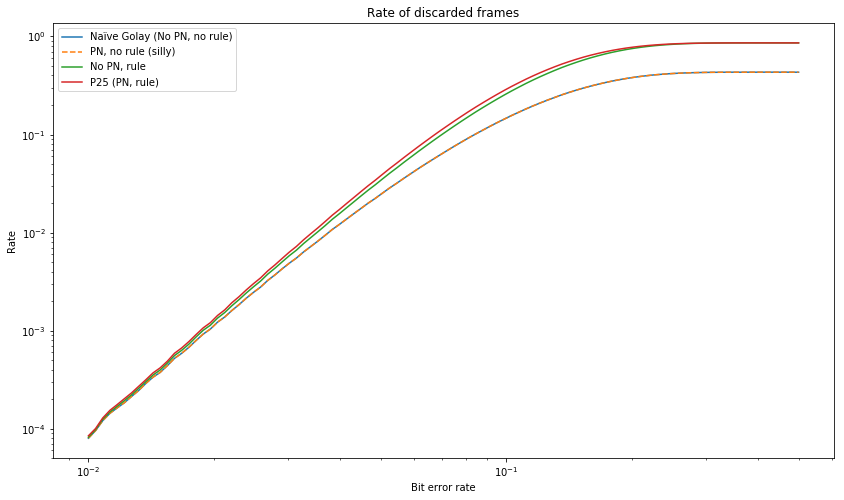

In [57]:
plt.loglog(ps, frame_repeats[0,0,:])
plt.loglog(ps, frame_repeats[0,1,:],'--')
plt.loglog(ps, frame_repeats[1,0,:])
plt.loglog(ps, frame_repeats[1,1,:])
plt.legend(['Naïve Golay (No PN, no rule)', 'PN, no rule (silly)', 'No PN, rule', 'P25 (PN, rule)'])
plt.title('Rate of discarded frames')
plt.ylabel('Rate')
plt.xlabel('Bit error rate');

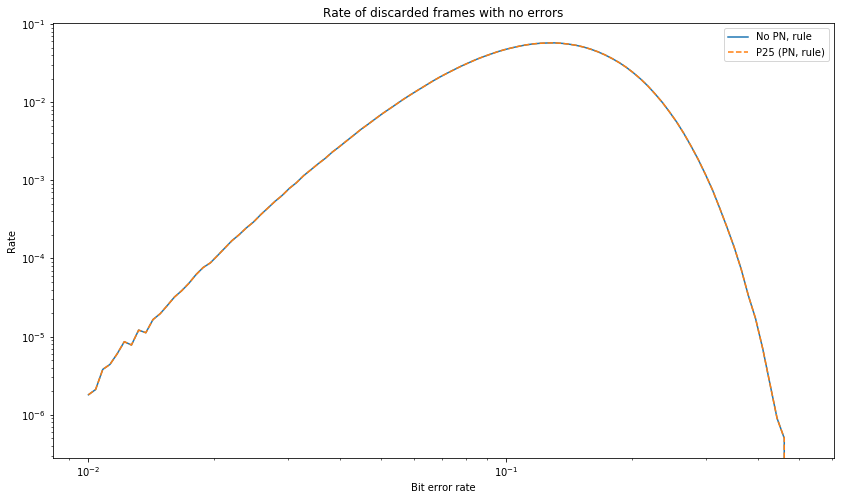

In [63]:
# These first two are zero
#plt.loglog(ps, false_positives[0,0,:])
#plt.loglog(ps, false_positives[0,1,:],'--')
plt.loglog(ps, false_positives[1,0,:])
plt.loglog(ps, false_positives[1,1,:],'--')
plt.legend(['No PN, rule', 'P25 (PN, rule)'])
plt.title('Rate of discarded frames with no errors')
plt.ylabel('Rate')
plt.xlabel('Bit error rate');

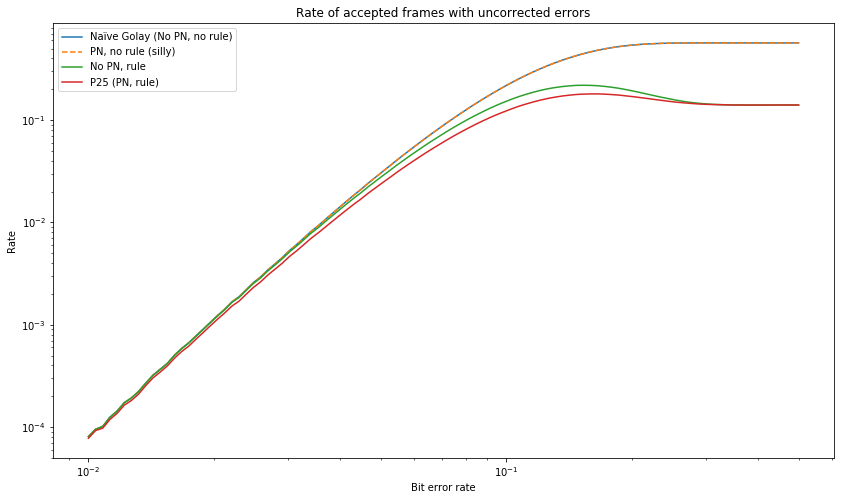

In [60]:
plt.loglog(ps, leaked_errors[0,0,:])
plt.loglog(ps, leaked_errors[0,1,:],'--')
plt.loglog(ps, leaked_errors[1,0,:])
plt.loglog(ps, leaked_errors[1,1,:])
plt.legend(['Naïve Golay (No PN, no rule)', 'PN, no rule (silly)', 'No PN, rule', 'P25 (PN, rule)'])
plt.title('Rate of accepted frames with uncorrected errors')
plt.ylabel('Rate')
plt.xlabel('Bit error rate');

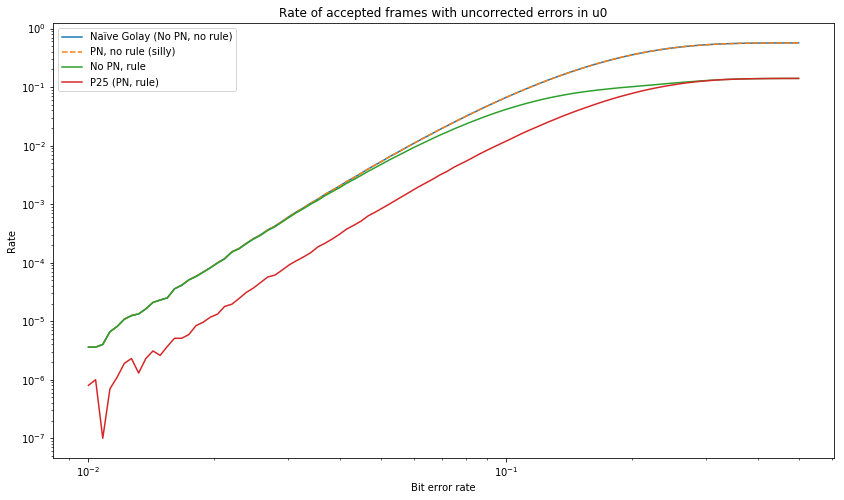

In [61]:
plt.loglog(ps, leaked_errors_u0[0,0,:])
plt.loglog(ps, leaked_errors_u0[0,1,:],'--')
plt.loglog(ps, leaked_errors_u0[1,0,:])
plt.loglog(ps, leaked_errors_u0[1,1,:])
plt.legend(['Naïve Golay (No PN, no rule)', 'PN, no rule (silly)', 'No PN, rule', 'P25 (PN, rule)'])
plt.title('Rate of accepted frames with uncorrected errors in u0')
plt.ylabel('Rate')
plt.xlabel('Bit error rate');

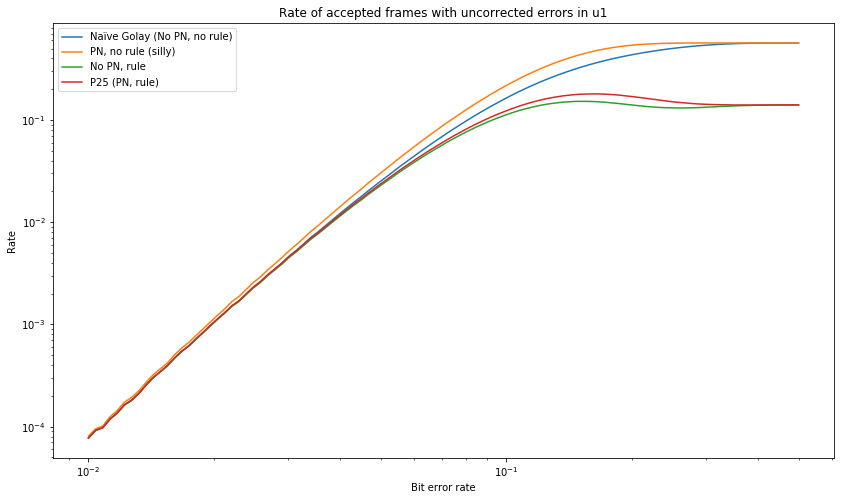

In [62]:
plt.loglog(ps, leaked_errors_u1[0,0,:])
plt.loglog(ps, leaked_errors_u1[0,1,:])
plt.loglog(ps, leaked_errors_u1[1,0,:])
plt.loglog(ps, leaked_errors_u1[1,1,:])
plt.legend(['Naïve Golay (No PN, no rule)', 'PN, no rule (silly)', 'No PN, rule', 'P25 (PN, rule)'])
plt.title('Rate of accepted frames with uncorrected errors in u1')
plt.ylabel('Rate')
plt.xlabel('Bit error rate');